For making annotation file smaller

cat Au3_CHR_hapA_v3.fasta.out.gff|grep -v 'CHR14_ab'|grep -v '#'|sed -e 's/APSI_AU3_HapA_CHR/Chr/' -e 's/;Target//' |awk -v OFS='\t' '{print $1"A",$4,$5,$6,$7,$8,$10}' >Au3_hapA_TE.bed

cat Au3_CHR_hapA_v3.fasta.out.gff|grep 'CHR14_ab'|sed -e 's/APSI_AU3_HapA_CHR/Chr/' -e 's/Chr14_ab/Chr14/' -e 's/;Target//' |awk -v OFS='\t' '{print $1"B",$4,$5,$6,$7,$8,$10}' >Au3_hapB_TE.bed

cat Au3_CHR_hapB_v3.fasta.out.gff|grep -v '#'|sed -e 's/APSI_AU3_HapB_CHR/Chr/'| awk -v OFS='\t' '{print $1"B",$4,$5,$6,$7,$8,$10}' >>Au3_hapB_TE.bed

cat Au3_hapA_TE.bed  Au3_hapB_TE.bed >Au3_TE.bed

In [1]:
import sys
import re
import os
import pandas as pd
import glob
from pathlib import Path
import Bio
import numpy as np
from pybedtools import BedTool

In [2]:
os.chdir('../../data/TE')

In [3]:
TE = pd.read_csv('Au3_TE.bed', sep='\t', header=None, comment='#')
TE.columns = ['seqname', 'start', 'end', 'Div', 'strand', 'phase', 'class']
TE['class'] = TE['class'].str.split(':').str[1]

In [4]:
chr5A_mfa = pd.read_csv('../MAT/CHR5A_mfa.bed', sep='\t', header=0)
chr5B_mfa = pd.read_csv('../MAT/CHR5B_mfa.bed', sep='\t', header=0)

In [5]:
mfa_genome = pd.read_csv('../MAT/mfa.bed', sep='\t', header=0)
mfa_genome['chrom'] = mfa_genome['chrom'].str.replace('CHR', 'Chr')
mfa_genome['chrom'] = mfa_genome['chrom'].str.replace('Chr14BA', 'Chr14B')

In [6]:
mfa_genome[mfa_genome['type'] == "mfa2"]

,chrom,start,end,strand,type,seq
0,Chr05A,20835253,20835349,+,mfa2,MIWFTFLFWEQVLIGKAENFPIFSKCSCIIH*
1,Chr05A,33855798,33855894,+,mfa2,MIWFTFLFWEQVLIGKAEFFPMFSKCSCIIY*
2,Chr05A,41092739,41092835,+,mfa2,MIWFTFLFWEQVLIGKAEIFPMFRQCICIIR*
3,Chr05A,60158164,60158260,+,mfa2,MIWFNFLFWEQVLIGKAEFFPMFRKCSCIIY*
4,Chr05A,51237010,51237106,+,mfa2,MILFTFLFWEQVFIGKAEFFPMFRKCICIIH*
...,...,...,...,...,...,...
413,Chr01A,9890553,9890649,-,mfa2,MIWFTFLFWEQVLIGKEEFFPMFSKCSCIIY*
414,Chr01A,76058218,76058314,-,mfa2,MIWFTFLFWEQVLIGKAEFFPMFSKCSCIIY*
415,Chr01A,54816364,54816460,-,mfa2,MTWFTFLFWEQELIGKAEFFLMFSKCSCIIY*
416,Chr01A,17653590,17653686,-,mfa2,MIWFAFLFWEQVLIVKAEFFPVFRKFICIIH*


In [7]:
mfa_genome.drop_duplicates(subset=['chrom', 'start', 'end'], inplace=True)

In [8]:
#Check the mating type region
chr05A_TE = TE[TE['seqname'] == 'Chr05A']
chr05A_TE = chr05A_TE[(chr05A_TE['start'] >=20000000) & (chr05A_TE['end'] <= 31000000)]
chr05A_TE['len'] = chr05A_TE['end'] - chr05A_TE['start']
chr05B_TE = TE[TE['seqname'] == 'Chr05B']
chr05B_TE = chr05B_TE[(chr05B_TE['start'] >=20000000) & (chr05B_TE['end'] <= 31000000)]
chr05B_TE['len'] = chr05B_TE['end'] - chr05B_TE['start']

In [9]:
CHR05_TE_top = chr05B_TE.groupby('class').sum('len').sort_values('len', ascending=False).head(100)
CHR05_TE_top = CHR05_TE_top.reset_index()
CHR05_TE_top = CHR05_TE_top['class'].tolist()

In [10]:
mfa_chr05B_df = pd.DataFrame()
chr05A_TE = TE[TE['seqname'] == 'Chr05A']
chr05A_TE_class = chr05A_TE['class'].unique()
chr05A_TE_class = chr05A_TE_class.tolist()
for i in chr05A_TE_class:
    tmp_df = chr05B_TE[chr05B_TE['class'] == i]
    tmp_TE_bed = tmp_df[['seqname', 'start', 'end']]
    tmp_TE_bed = tmp_TE_bed.rename(columns={'seqname':'chrom', 'start':'start', 'end':'end'})
    tmp_TE_bed['start'] = tmp_TE_bed['start'].astype(int)
    tmp_TE_bed['end'] = tmp_TE_bed['end'].astype(int)
    tmp_TE_bed = BedTool.from_dataframe(tmp_TE_bed)
    tmp_TE_bed = tmp_TE_bed.merge()
    for mfa in chr5B_mfa['name'].unique():
        tmp_mfa = chr5B_mfa[chr5B_mfa['name'] == mfa]
        tmp_mfa = tmp_mfa[['chrom', 'start', 'end']]
        tmp_mfa = BedTool.from_dataframe(tmp_mfa)
        tmp_mfa = tmp_mfa.intersect(tmp_TE_bed, wa=True, wb=True)
        #Count the number of mfa in each TE
        tmp_mfa_df = tmp_mfa.to_dataframe()
        if len(tmp_mfa_df) > 0:
            tmp_mfa_df['name'] = mfa
            tmp_mfa_df['TE'] = i
            mfa_chr05B_df = pd.concat([mfa_chr05B_df, tmp_mfa_df])

In [11]:
TE_bed_df = TE[['seqname', 'start', 'end']]
TE_bed_df = TE_bed_df.rename(columns={'seqname':'chrom', 'start':'start', 'end':'end'})
#merge the TE_bed_df
TE_bed_df['start'] = TE_bed_df['start'].astype(int)
TE_bed_df['end'] = TE_bed_df['end'].astype(int)
TE_bed_df = BedTool.from_dataframe(TE_bed_df)
TE_bed_df = TE_bed_df.merge()
mfa_genome_df = mfa_genome[['chrom', 'start', 'end']]
mfa_genome_df['chrom'] = mfa_genome_df['chrom'].str.replace('CHR', 'Chr')
mfa_genome_df = BedTool.from_dataframe(mfa_genome_df)
#sort the mfa_genome_df
mfa_genome_df = mfa_genome_df.sort()
mfa_TE_intersect = mfa_genome_df.intersect(TE_bed_df, wa=True, wb=True)
mfa_TE_intersect_df = mfa_TE_intersect.to_dataframe()

/tmp/ipykernel_3748/4220758156.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mfa_genome_df['chrom'] = mfa_genome_df['chrom'].str.replace('CHR', 'Chr')
***** WARNING: File /tmp/pybedtools.b8e0x0u9.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	1	11934

***** WARNING: File /tmp/pybedtools.b8e0x0u9.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	1	11934



In [12]:
#Phase the mfa_TE_intersect_df and mfa
#mfa_TE_merge = pd.merge(mfa_TE_intersect_df, mfa_genome, on=['chrom', 'start', 'end'], how='left')
#Find which TE is in the mating type region
#mfa_TE_merge_bed = mfa_TE_merge[['name', 'score', 'strand_x']]
#mfa_TE_merge_bed.columns = ['chrom', 'start', 'end']
inset_TE_df = pd.DataFrame()
for index, row in mfa_genome.iterrows():
    tmp_start = row['start']
    tmp_end = row['end']
    tmp_chr = row['chrom']
    type = row['type']
    tmp_TE = TE[(TE['start'] <= tmp_start) & (TE['end'] >= tmp_end)& (TE['seqname'] == tmp_chr)]
    tmp_TE = tmp_TE.copy()
    tmp_TE['type'] = type
    tmp_TE['mfa_chr'] = tmp_chr
    tmp_TE['mfa_start'] = tmp_start
    tmp_TE['mfa_end'] = tmp_end
    tmp_TE['mfa_seq']= row['seq']
    inset_TE_df = pd.concat([inset_TE_df, tmp_TE])
    tmp_TE = TE[(TE['start'] >= tmp_start) & (TE['start'] <= tmp_end)& (TE['seqname'] == tmp_chr)]
    tmp_TE = tmp_TE.copy()
    tmp_TE['type'] = type
    tmp_TE['mfa_chr'] = tmp_chr
    tmp_TE['mfa_start'] = tmp_start
    tmp_TE['mfa_end'] = tmp_end
    tmp_TE['mfa_seq']= row['seq']
    inset_TE_df = pd.concat([inset_TE_df, tmp_TE])
    tmp_TE = TE[(TE['end'] >= tmp_start) & (TE['end'] <= tmp_end)& (TE['seqname'] == tmp_chr)]
    tmp_TE = tmp_TE.copy()
    tmp_TE['type'] = type
    tmp_TE['mfa_chr'] = tmp_chr
    tmp_TE['mfa_start'] = tmp_start
    tmp_TE['mfa_end'] = tmp_end
    tmp_TE['mfa_seq']= row['seq']
    inset_TE_df = pd.concat([inset_TE_df, tmp_TE])



In [17]:
#count occurence of tach class
#inset_TE_df['class'].value_counts()
count_mfa_TE = inset_TE_df[['class','mfa_seq']].value_counts().reset_index()
count_mfa_TE

,class,mfa_seq,count
0,DTX-incomp_MCL22_MR_P2A_300Mb-B-P252.0-Map5,MIWFTFLFWEQVLIGKAEFFPMFSKCSCIIY*,16
1,DTX-incomp-chim_MCL13_MR_P2A_300Mb-L-B175-Map1,MIWFTFLFWEQELIGKAEFFPMFSKCSCIIY*,16
2,DTX-incomp-chim_MCL23_MR_P2A_300Mb-L-B69-Map1,MIWFTFLFWEQVLIGKAEFFPMFSKCSCIIY*,12
3,DTX-incomp-chim_MCL203_MR_P2A_300Mb-L-B556-Map...,MIWFTFLFWEQELIGKAEFFPMFSKCSCIIY*,9
4,DTX-incomp_MCL13_MR_P2A_100Mb_RS_8_reversed,MIWFTFLFWEQVLIGKAEFFPMFSKCSCIIY*,8
...,...,...,...
312,DTX-incomp-chim_MCL203_MR_P2A_300Mb-L-B556-Map...,MIWFTFLFWEQGLIGKAEFFPMFSKCSCIIY*,1
313,DTX-incomp-chim_MCL203_MR_P2A_300Mb-L-B556-Map...,MIWFTFLFWEQEWIGKAELFPMFSKCSCIIY*,1
314,DTX-incomp-chim_MCL203_MR_P2A_300Mb-L-B556-Map...,MIWFTFLFWEQELIGKVEFFQMFSECSCIIY*,1
315,DTX-incomp-chim_MCL203_MR_P2A_300Mb-L-B556-Map...,MIWFTFLFWEQELIGKVEFFPMFSKCSCIIY*,1


In [20]:
tmp = inset_TE_df[inset_TE_df['class'] == 'DTX-incomp_MCL13_MR_P2A_100Mb_RS_8_reversed']
#Caculate mean of divergence rate
tmp['Div'] = tmp['Div'].astype(float)
tmp['Div'].mean()



/tmp/ipykernel_3748/1645147687.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Div'] = tmp['Div'].astype(float)


8.040350877192983

In [20]:
inset_TE_df.drop_duplicates(subset=['mfa_chr', 'mfa_start', 'mfa_end'], inplace=True)


In [21]:
inset_TE_df

,seqname,start,end,Div,strand,phase,class,type,mfa_chr,mfa_start,mfa_end,mfa_seq
349102,Chr05A,20834253,20836178,19.0,-,.,DTX-incomp_MCL13_MR_P2A_100Mb_RS_8_reversed,mfa2,Chr05A,20835253,20835349,MIWFTFLFWEQVLIGKAENFPIFSKCSCIIH*
362015,Chr05A,33854253,33856874,7.8,+,.,DTX-incomp-chim_MCL22_MR_P2A_300Mb-L-B179-Map1...,mfa2,Chr05A,33855798,33855894,MIWFTFLFWEQVLIGKAEFFPMFSKCSCIIY*
369270,Chr05A,41091114,41093091,9.4,-,.,DTX-incomp-chim_MCL1_MR_P2A_300Mb-L-B626-Map1,mfa2,Chr05A,41092739,41092835,MIWFTFLFWEQVLIGKAEIFPMFRQCICIIR*
389556,Chr05A,60156596,60163146,5.3,-,.,DTX-incomp-chim_MCL13_MR_P2A_300Mb-L-B2001-Map1,mfa2,Chr05A,60158164,60158260,MIWFNFLFWEQVLIGKAEFFPMFRKCSCIIY*
380055,Chr05A,51235449,51238990,8.2,-,.,DTX-incomp-chim_MCL1_MR_P2A_300Mb-L-B970-Map1_...,mfa2,Chr05A,51237010,51237106,MILFTFLFWEQVFIGKAEFFPMFRKCICIIH*
...,...,...,...,...,...,...,...,...,...,...,...,...
9884,Chr01A,9882145,9891853,5.0,+,.,DTX-incomp_MCL13_MR_P2A_100Mb_RS_8_reversed,mfa2,Chr01A,9890553,9890649,MIWFTFLFWEQVLIGKEEFFPMFSKCSCIIY*
76841,Chr01A,76045113,76059637,4.5,+,.,DTX-incomp-chim_MCL96_MR_P2A_300Mb-L-B107-Map1,mfa2,Chr01A,76058218,76058314,MIWFTFLFWEQVLIGKAEFFPMFSKCSCIIY*
54824,Chr01A,54803682,54818085,6.7,+,.,DTX-incomp-chim_MCL13_MR_P2A_300Mb-L-B175-Map1,mfa2,Chr01A,54816364,54816460,MTWFTFLFWEQELIGKAEFFLMFSKCSCIIY*
16732,Chr01A,17653037,17655232,8.5,+,.,DTX-incomp-chim_MCL1_MR_P2A_300Mb-L-B626-Map1,mfa2,Chr01A,17653590,17653686,MIWFAFLFWEQVLIVKAEFFPVFRKFICIIH*


In [71]:
inset_TE_df['seqname'].unique()

array(['Chr05A', 'Chr12B', 'Chr12A', 'Chr09A', 'Chr08B', 'Chr08A',
       'Chr15B', 'Chr13B', 'Chr11B', 'Chr10B', 'Chr09B', 'Chr06B',
       'Chr05B', 'Chr04B', 'Chr03B', 'Chr02B', 'Chr01B', 'Chr14B',
       'Chr11A', 'Chr10A', 'Chr07A', 'Chr06A', 'Chr04A', 'Chr03A',
       'Chr02A', 'Chr15A', 'Chr17B', 'Chr16B', 'Chr07B', 'Chr17A',
       'Chr16A', 'Chr14A', 'Chr01A', 'Chr18B', 'Chr13A', 'Chr18A'],
      dtype=object)

/tmp/ipykernel_206137/1554656722.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='class', y='cov', data=test, palette='viridis')


Text(0.5, 1.0, 'Top 20 TE in Chr05B')

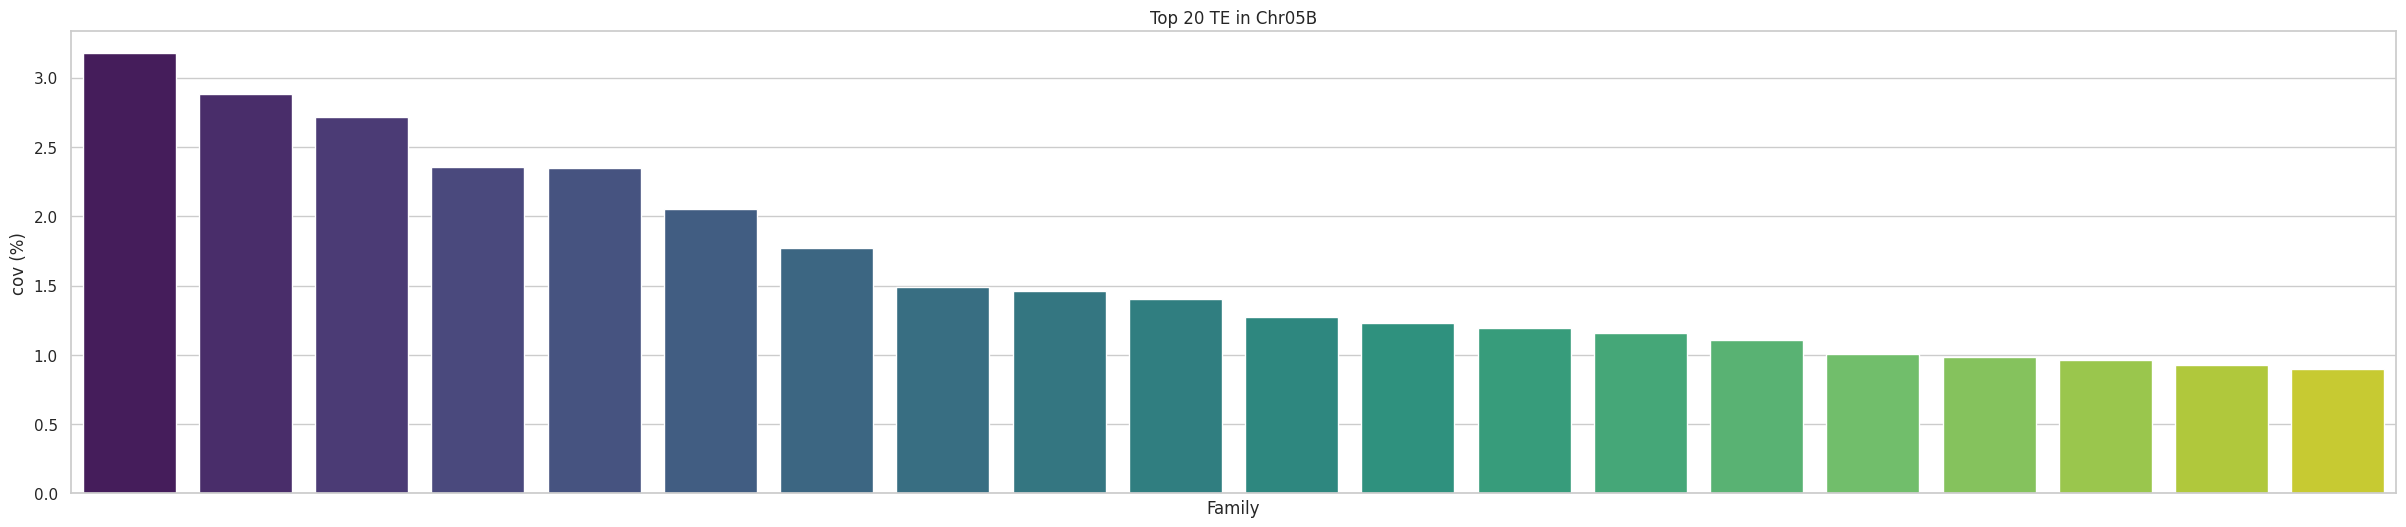

In [87]:
test = chr05B_TE.groupby('class').sum('len').sort_values('len', ascending=False).head(20).reset_index().drop(['start', 'end','Div'], axis=1)
test['cov'] = test['len']*100/11000000
sns.set_theme(style="whitegrid")
plt.figure(figsize=(30, 6))
sns.barplot(x='class', y='cov', data=test, palette='viridis')
plt.xlabel('Family')
plt.ylabel('cov (%)')
#Not show the x-axis label, put for legend instead
plt.xticks([])
#Make color legend

plt.title('Top 20 TE in Chr05B')

/tmp/ipykernel_206137/3643425775.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='class', y='cov', data=test, palette='viridis')


Text(0.5, 1.0, 'Top 20 TE in Chr05A')

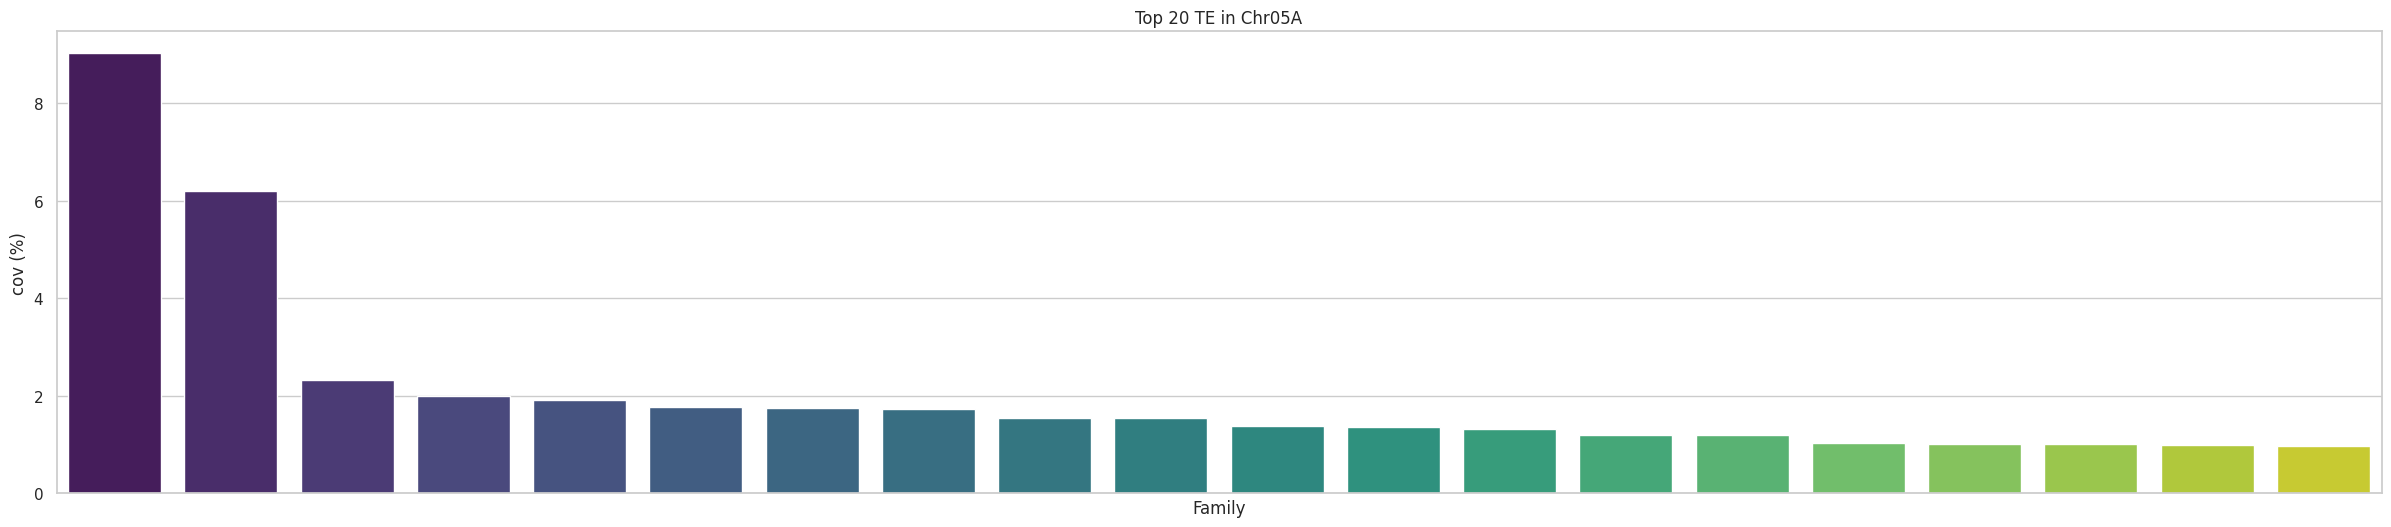

In [85]:
test = chr05A_TE.groupby('class').sum('len').sort_values('len', ascending=False).head(20).reset_index().drop(['start', 'end','Div'], axis=1)
test['cov'] = test['len']*100/11000000
#plot the top 20 TE in chr05A
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(30, 6))
sns.barplot(x='class', y='cov', data=test, palette='viridis')
plt.xlabel('Family')
plt.ylabel('cov (%)')
#Not show the x-axis label, put for legend instead
plt.xticks([])
#Make color legend

plt.title('Top 20 TE in Chr05A')

In [79]:
chr05A_TE

,seqname,start,end,Div,strand,phase,class,len
348352,Chr05A,20000809,20001256.0,5.8,+,.,RLX-comp_MCL1_MR_P2A_300Mb-L-B723-Map1,447.0
348353,Chr05A,20001081,20001326.0,10.7,+,.,RLX-incomp_MCL3_MR_P2A_300Mb-L-B1453-Map1,245.0
348354,Chr05A,20001143,20001328.0,4.7,+,.,DTX-incomp-chim_MCL3_MR_P2A_300Mb-L-B808-Map1,185.0
348355,Chr05A,20001166,20001370.0,13.2,+,.,RLX-incomp-chim_MCL3_MR_P2A_300Mb-L-B699-Map1_...,204.0
348356,Chr05A,20001166,20001335.0,3.5,+,.,RLX-comp_MCL3_MR_P2A_300Mb-L-B2220-Map1,169.0
...,...,...,...,...,...,...,...,...
358721,Chr05A,30992634,30992700.0,16.9,-,.,RLX-comp_MCL1_MR_P2A_300Mb-L-B1802-Map1_reversed,66.0
358722,Chr05A,30992659,30992764.0,19.4,-,.,RLX-incomp-chim_MCL1_MR_P2A_300Mb-L-B126-Map1_...,105.0
358723,Chr05A,30992675,30992777.0,18.4,-,.,RLX-incomp_MCL1_MR_P2A_300Mb-L-B2288-Map1_reve...,102.0
358724,Chr05A,30992675,30992765.0,8.8,-,.,RLX-comp_MCL369_MR_P2A_300Mb-L-B3963-Map1_reve...,90.0


In [53]:
test_mfa.to_dataframe()

,chrom,start,end
0,Chr05B,22247080,22247239
1,Chr05B,22473499,22473658
2,Chr05B,22532970,22533129
3,Chr05B,22585385,22585544
4,Chr05B,22710341,22710500
...,...,...,...
133,Chr05B,27646963,27647122
134,Chr05B,27351848,27352007
135,Chr05B,27945794,27945953
136,Chr05B,24693727,24693883
